
<div style="padding:20px;color:white;margin:0;font-size:175%;text-align:center;display:fill;border-radius:5px;background-color:#01b8cc;overflow:hidden;font-weight:500">American_Express_Credit_Card_Payment_Risk_Forecasting_Project</div>



## 1. Project Objective

In today’s world, cashless transactions are the norm. Whether it's buying a coffee, shopping online, or making restaurant reservations, credit cards have become indispensable, offering the convenience of purchasing without the need for carrying large amounts of cash. Furthermore, credit cards allow users to make purchases with the flexibility to pay back the balance over time.


However, this convenience brings a challenge for card issuers: how can they ensure that cardholders will repay the amount charged on their credit cards? Determining creditworthiness and the likelihood of repayment is a complex problem, and while many models and solutions exist, there is still significant room for improvement—this is the focus of this project.


Credit default prediction is crucial for managing risk in the consumer lending business. Predicting defaults enables lenders to make more informed decisions, improving both customer experience and business profitability. Current models help mitigate risk, but the goal is to develop better models that outperform existing ones.


American Express, the largest global issuer of payment cards, plays a significant role in the world of cashless payments. In 2016, credit cards running on the American Express network represented 22.9% of the total dollar volume of credit card transactions in the United States. American Express provides access to products and services that enhance lives and drive business success.


The goal of this project is to build a model capable of predicting the probability that a customer will default on their credit card payments based on their monthly customer profile.


## 2. Data Overview
   
The target variable in this dataset is binary, indicating whether a customer defaulted on their credit card payment. This is calculated by observing an 18-month performance window after the latest credit card statement. If a customer fails to pay the due amount within 120 days of the latest statement, it is considered a default event.

The dataset includes aggregated profile features for each customer at each statement date. These features are categorized as follows:

D_*: Delinquency variables
Delinquency refers to late or overdue payments on credit cards, loans, or other financial obligations. In this context, an account is considered delinquent if a payment is 30 days or more past due. Repeated delinquencies can lead to default.

S_*: Spend variables
These variables represent each customer’s spending patterns—how they spend, on what, and how much.

P_*: Payment variables
These variables capture the history of payments made by the customer for their loans.

B_*: Balance variables
These variables track the balance information on the credit card account.

R_*: Risk variables
These variables relate to the overall risk profile of the customer.

In addition, some features are categorical:

B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126
Task:
The task is to predict the probability that a customer will default (target = 1) on their payment in the future, using the provided features.


In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings, gc
warnings.filterwarnings("ignore")


The dataset Source from kaggle competition has a considerable dataset size more than 14GB . If you read the original csv files, the data barely fits into memory. That's why we read the data from @munumbutt's [AMEX-Feather-Dataset](https://www.kaggle.com/datasets/munumbutt/amexfeather). In this Feather file, the floating point precision has been reduced from 64 bit to 16 bit. And reading a Feather file is faster than reading a csv file because the Feather file format is binary.

What is Feather?

Feather is a fast, lightweight, and easy-to-use binary file format for storing data frames. It has a few specific design goals:

- Lightweight, minimal API: make pushing data frames in and out of memory as simple as possible

- Language agnostic: Feather files are the same whether written by Python or R code. Other languages can read and write Feather files, too.

- High read and write performance. When possible, Feather operations should be bound by local disk performance.

Feather currently supports the following column types:

- A wide range of numeric types (int8, int16, int32, int64, uint8, uint16, uint32, uint64, float, double).
- Logical/boolean values.
- Dates, times, and timestamps.
- Factors/categorical variables that have fixed set of possible values.
- UTF-8 encoded strings.
- Arbitrary binary data.

What should you not use Feather for?

- Feather is not designed for long-term data storage. At this time, we do not guarantee that the file format will be stable between versions. Instead, use Feather for quickly exchanging data between Python and R code, or for short-term storage of data frames as part of some analysis.

In [2]:
%%time
train = pd.read_feather('train_data.ftr')
test = pd.read_feather('test_data.ftr')


CPU times: user 17.6 s, sys: 8.03 s, total: 25.6 s
Wall time: 44.2 s


In [3]:
print(f'Train data memory usage: {train.memory_usage().sum() / 1e9} GBytes')
print(f'Test data memory usage:  {test.memory_usage().sum() / 1e9} GBytes')

Train data memory usage: 2.151736827 GBytes
Test data memory usage:  4.329595558 GBytes


Test data is twice the size of the train data and this puts us under some constraints:
- We need to have an eye on memory efficiency. We have to avoid keeping unnecessary copies of the data or unnecessary copies of models.


In [4]:
print(f"There are {train.customer_ID .nunique()} customers in the training set and {train.shape[1]} features.")
print(f"There are {test.customer_ID .nunique()} customers in the test set and {test.shape[1]} features.")

There are 458913 customers in the training set and 191 features.
There are 924621 customers in the test set and 190 features.


We can see that we have double the number of customers in our test set.

In [5]:
print(f"The train data begins on {train['S_2'].min().strftime('%m-%d-%Y')} and ends on {train['S_2'].max().strftime('%m-%d-%Y')}.")

print(f"The test data begins on {test['S_2'].min().strftime('%m-%d-%Y')} and ends on {test['S_2'].max().strftime('%m-%d-%Y')}.")


The train data begins on 03-01-2017 and ends on 03-31-2018.
The test data begins on 04-01-2018 and ends on 10-31-2019.


In [6]:
train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 191 columns):
 #    Column       Non-Null Count    Dtype         
---   ------       --------------    -----         
 0    customer_ID  5531451 non-null  object        
 1    S_2          5531451 non-null  datetime64[ns]
 2    P_2          5485466 non-null  float16       
 3    D_39         5531451 non-null  float16       
 4    B_1          5531451 non-null  float16       
 5    B_2          5529435 non-null  float16       
 6    R_1          5531451 non-null  float16       
 7    S_3          4510907 non-null  float16       
 8    D_41         5529435 non-null  float16       
 9    B_3          5529435 non-null  float16       
 10   D_42         791314 non-null   float16       
 11   D_43         3873055 non-null  float16       
 12   D_44         5257132 non-null  float16       
 13   B_4          5531451 non-null  float16       
 14   D_45         5529434 non-null  float16       
 1

**There are many columns with missing values: Dropping all columns which have missing values is not a sensible strategy. But also some columns have too much mising values that we can not impute them we have to figure out how to handle this.**

### Counting the statements per customer

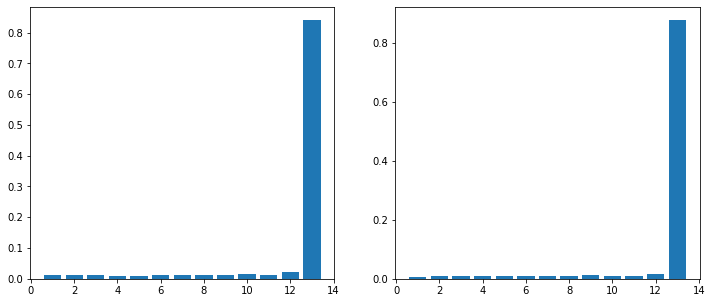

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_sc = train.customer_ID.value_counts().value_counts(normalize=True).sort_index(ascending=False)


ax1.bar(x= train_sc.index, height=train_sc.values)

test_sc = test.customer_ID.value_counts().value_counts(normalize=True).sort_index(ascending=False)
ax2.bar(x= test_sc.index, height=test_sc.values)

plt.show()

Takeouts:
- There are 80% of Customers present in training dataset have 13 statments and the other 20 % of the customers have between 1 and 12 statements, and this also true for the test set.
- I read from other solutions that they use the last statment as representative for the customer and you can refer to this discussion [here](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327094/)

In [8]:
train =  train.groupby('customer_ID').tail(1)\
            .set_index('customer_ID')
test =  test.groupby('customer_ID').tail(1)\
            .set_index('customer_ID')

In [9]:
train.columns

Index(['S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       ...
       'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=190)

In [10]:
print(f'Train data memory usage: {train.memory_usage().sum() / 1e9} GBytes')
print(f'Test data memory usage:  {test.memory_usage().sum() / 1e9} GBytes')

Train data memory usage: 0.178519417 GBytes
Test data memory usage:  0.352282709 GBytes


In [11]:
print(f"The train data begins on {train['S_2'].min().strftime('%m-%d-%Y')} and ends on {train['S_2'].max().strftime('%m-%d-%Y')}.")
print(f"The test data begins on {test['S_2'].min().strftime('%m-%d-%Y')} and ends on {test['S_2'].max().strftime('%m-%d-%Y')}.")

The train data begins on 03-01-2018 and ends on 03-31-2018.
The test data begins on 04-01-2019 and ends on 10-31-2019.


In the training set, the last statement of all customers was in March 2018, while in the test set the date of customers' last statements range from April through October 2019.



# <b><span >2.1 |</span><span > Exploratory Data Analysis </span></b>

In [12]:
target=train.target.value_counts(normalize=True)
print(target)

0    0.741066
1    0.258934
Name: target, dtype: float64


In [13]:
target.rename(index={1:'Default',0:'Paid'},inplace=True)

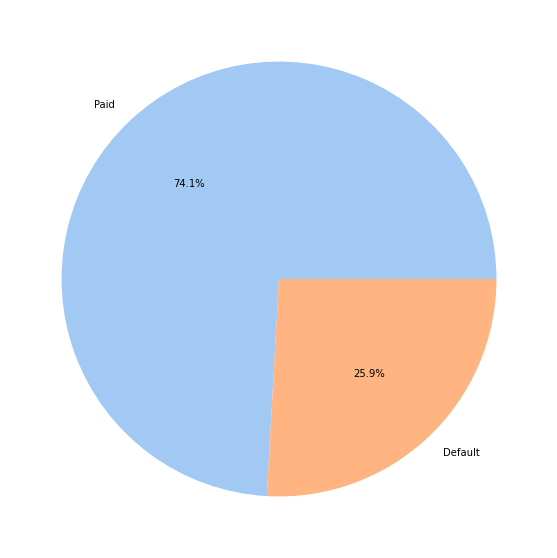

In [14]:
fig = plt.figure(figsize=(10, 10))
colors = sns.color_palette('pastel')[0:5]
plt.pie( target.values,labels=target.index,colors = colors, autopct='%.01f%%')
plt.show()

We start by reading the labels for the training data. There are neither missing values nor duplicated customer_IDs. 
Of the 458913 customer_IDs, 340000 (74 %) have a label of 0 (good customer, no default) and 119000 (26 %) have a label of 1 (bad customer, default).

We know that the good customers have been subsampled by a factor of 20; this means that in reality 98.7 % of the customers are good; 1.3 % are bad.



In [15]:
train.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Data columns (total 190 columns):
 #    Column  Non-Null Count   Dtype         
---   ------  --------------   -----         
 0    S_2     458913 non-null  datetime64[ns]
 1    P_2     455944 non-null  float16       
 2    D_39    458913 non-null  float16       
 3    B_1     458913 non-null  float16       
 4    B_2     458882 non-null  float16       
 5    R_1     458913 non-null  float16       
 6    S_3     373943 non-null  float16       
 7    D_41    458882 non-null  float16       
 8    B_3     458882 non-null  float16       
 9    D_42    59910 non-null   float16       
 10   D_43    324591 non-null  float16       
 11   D_44    436618 non-null  float16       
 12   B_4     458913 non-null  float16       
 13   D_45    458882 non-null  float16       
 14   B_5     458913 non-null  float

In [16]:
null_train=round((train.isna().sum()/train.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null_train=null_train.to_frame().rename(columns={0:'Train_Missing %'})
null_train.head(40)

,Train_Missing %
D_87,99.86%
D_88,99.82%
D_108,99.43%
D_111,99.2%
D_110,99.2%
B_39,99.11%
D_73,99.08%
B_42,98.66%
D_137,96.43%
D_134,96.43%


In [17]:
null_test=round((test.isna().sum()/test.shape[0]*100),2).sort_values(ascending=False).astype(str)+('%')
null_test=null_test.to_frame().rename(columns={0:'Test_Missing %'})
null_test.head(40)

,Test_Missing %
D_87,99.83%
D_88,99.83%
D_108,99.51%
D_111,98.89%
D_110,98.89%
B_39,98.74%
D_73,98.52%
B_42,98.03%
D_134,97.09%
D_138,97.09%


In [18]:
null_total = null_train.join(null_test)

In [19]:
null_total.head(50)

,Train_Missing %,Test_Missing %
D_87,99.86%,99.83%
D_88,99.82%,99.83%
D_108,99.43%,99.51%
D_111,99.2%,98.89%
D_110,99.2%,98.89%
B_39,99.11%,98.74%
D_73,99.08%,98.52%
B_42,98.66%,98.03%
D_137,96.43%,97.09%
D_134,96.43%,97.09%


In [20]:
null_total[null_total["Train_Missing %"]=="0.0%"].head()

,Train_Missing %,Test_Missing %
D_96,0.0%,0.0%
S_26,0.0%,0.09%
D_102,0.0%,0.0%
R_25,0.0%,0.0%
S_2,0.0%,0.0%


In [21]:
cols_removal_considered = list(null_total.index[0:25])

I considered the removal of the columns having too much missing values but let's check their correlation with the target variable to know if they will present additional information to the models

### <b><span >2.1.1 |</span><span > Target Analysis </span></b>

In [22]:
corr=train.corr()
corr_target=corr['target'].sort_values(ascending=False)[1:-1]
pal=sns.color_palette("Reds_r",135).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig = go.Figure()
fig.add_trace(go.Bar(x=corr_target[corr_target>=0], y=corr_target[corr_target>=0].index, 
                     marker_color=rgb, orientation='h', 
                     marker_line=dict(color=pal,width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
pal=sns.color_palette("Blues",100).as_hex()
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig.add_trace(go.Bar(x=corr_target[corr_target<0], y=corr_target[corr_target<0].index, 
                     marker_color=rgb[25:], orientation='h', 
                     marker_line=dict(color=pal[25:],width=2), name='',
                     hovertemplate='%{y} correlation with target: %{x:.3f}',
                     showlegend=False))
fig.update_layout(title="Feature Correlations with Target",
                  xaxis_title="Correlation", margin=dict(l=150),
                  height=3000, width=700, hovermode='closest')
fig.show()

In [23]:
corr_target = corr_target.to_frame().rename(columns={0:'Correlation'})

In [24]:
#corr_target.loc[[x for x in cols_removal_considered if x not in ('D_87', 'D_66')]].sort_values(by="target")

**This correlation shows that all the variables selected for removal are not highly correlated with the target variable so it can be safe to remove them although the corr() function only calculates the linear correlation between variables but we can use it as indication**

### <b><span >2.1.2 |</span><span > Analysis For Delinquency variables: </span></b> 

In [25]:
cat_cols=['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

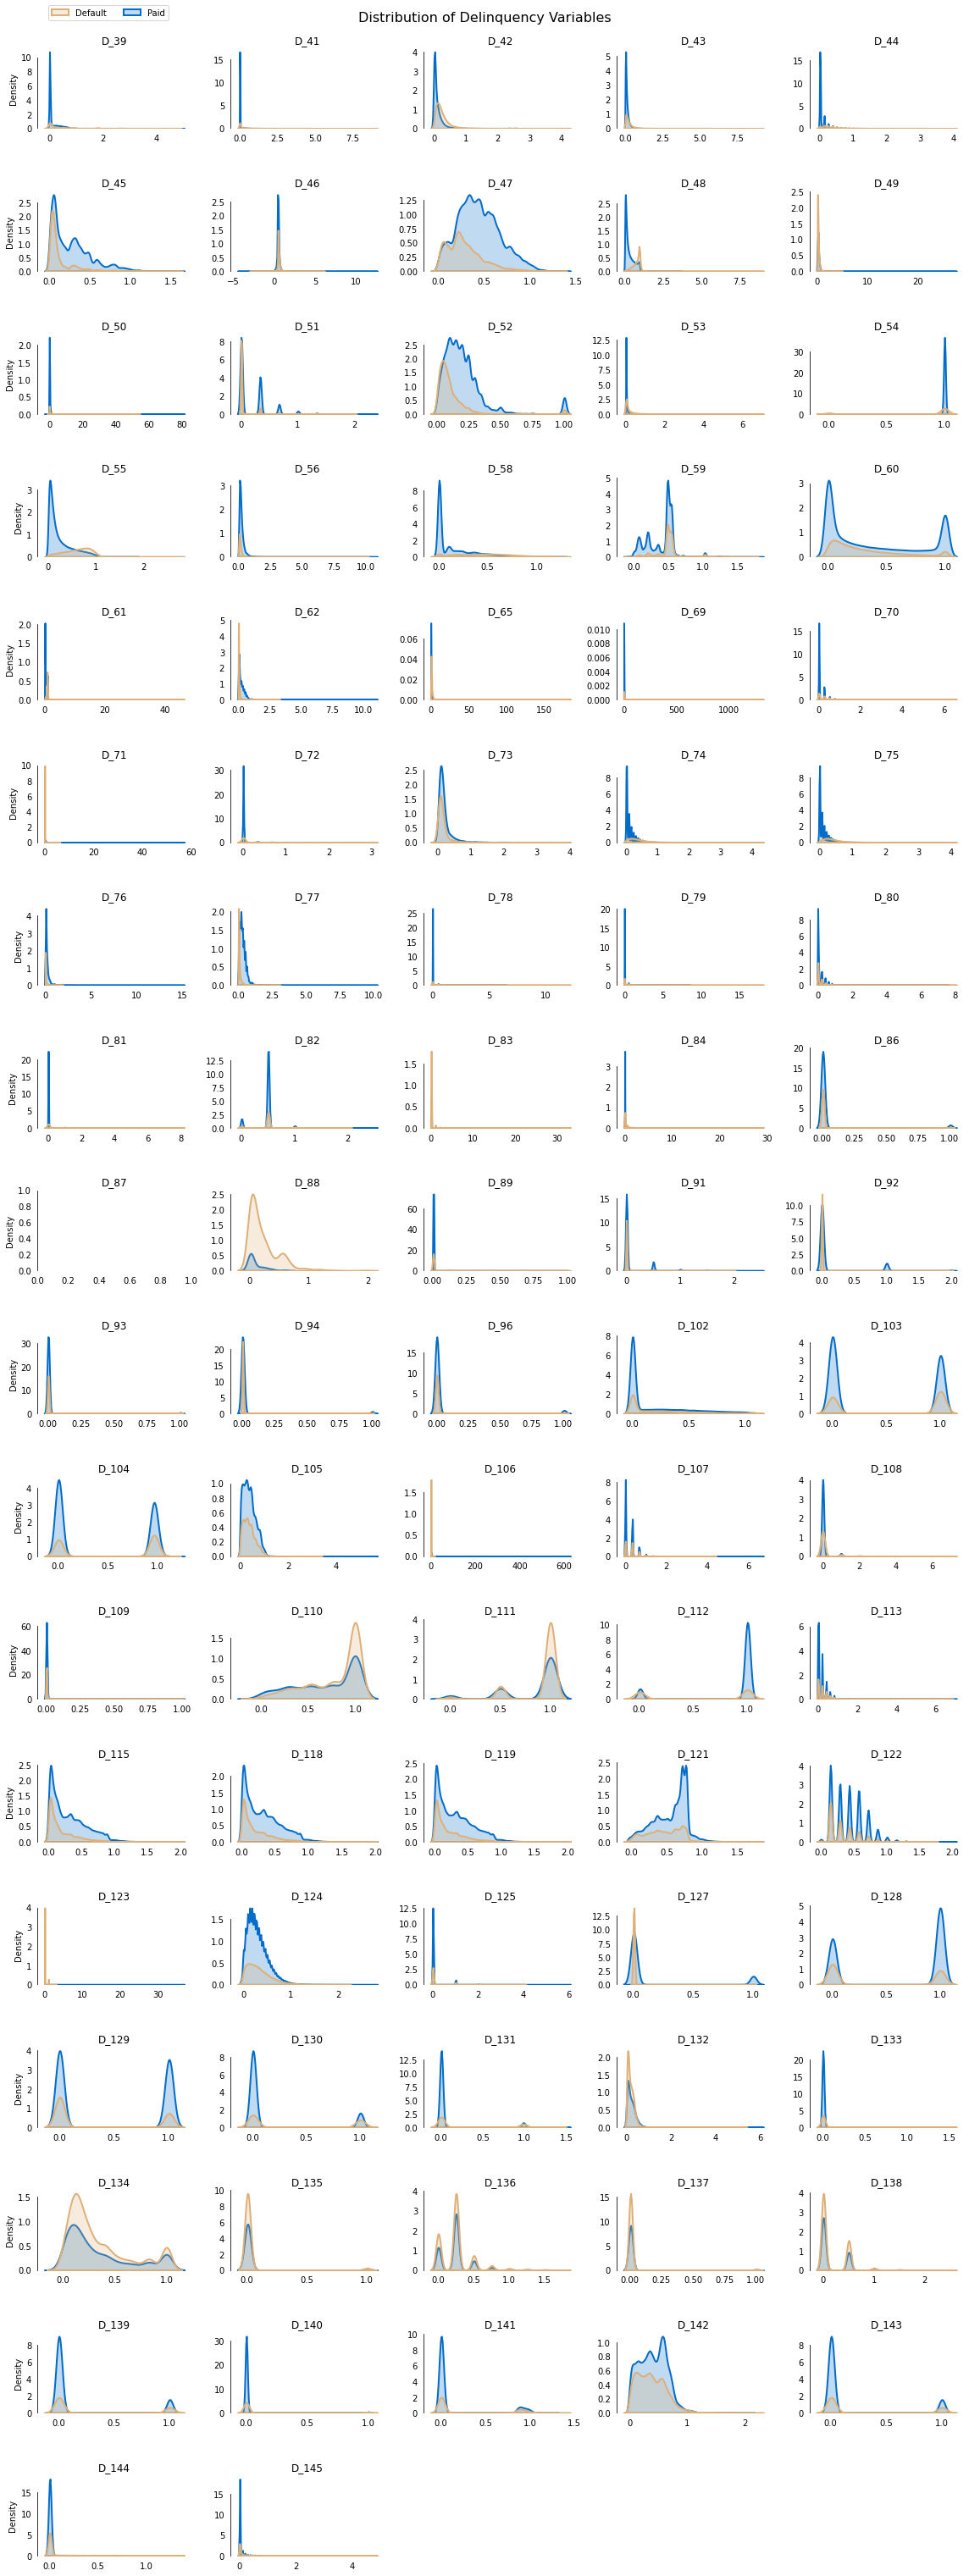

In [26]:

cols=[col for col in train.columns if (col.startswith(('D','t'))) & (col not in cat_cols)]
#print(cols)
pal = ['#016CC9','#DEB078']
plot_df=train[cols]
fig, ax = plt.subplots(18,5, figsize=(16,54))
fig.suptitle('Distribution of Delinquency Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*18
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(2,5):
    ax[17,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.983))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

***We can see here that there is no feature with normal distribution it is either skewed one or multimodal or other forms of distribution***


*** We have some shapes that seem categorial like: D_103,D_109,D_111,D_127,D_128,
D_129,D_135,D_137,D_139,D_140,D_143,D_86,
D_92,D_93,D_94,D_96,D_89,D_91,D_81,D_82,
D_123,D_125,D_108 ***

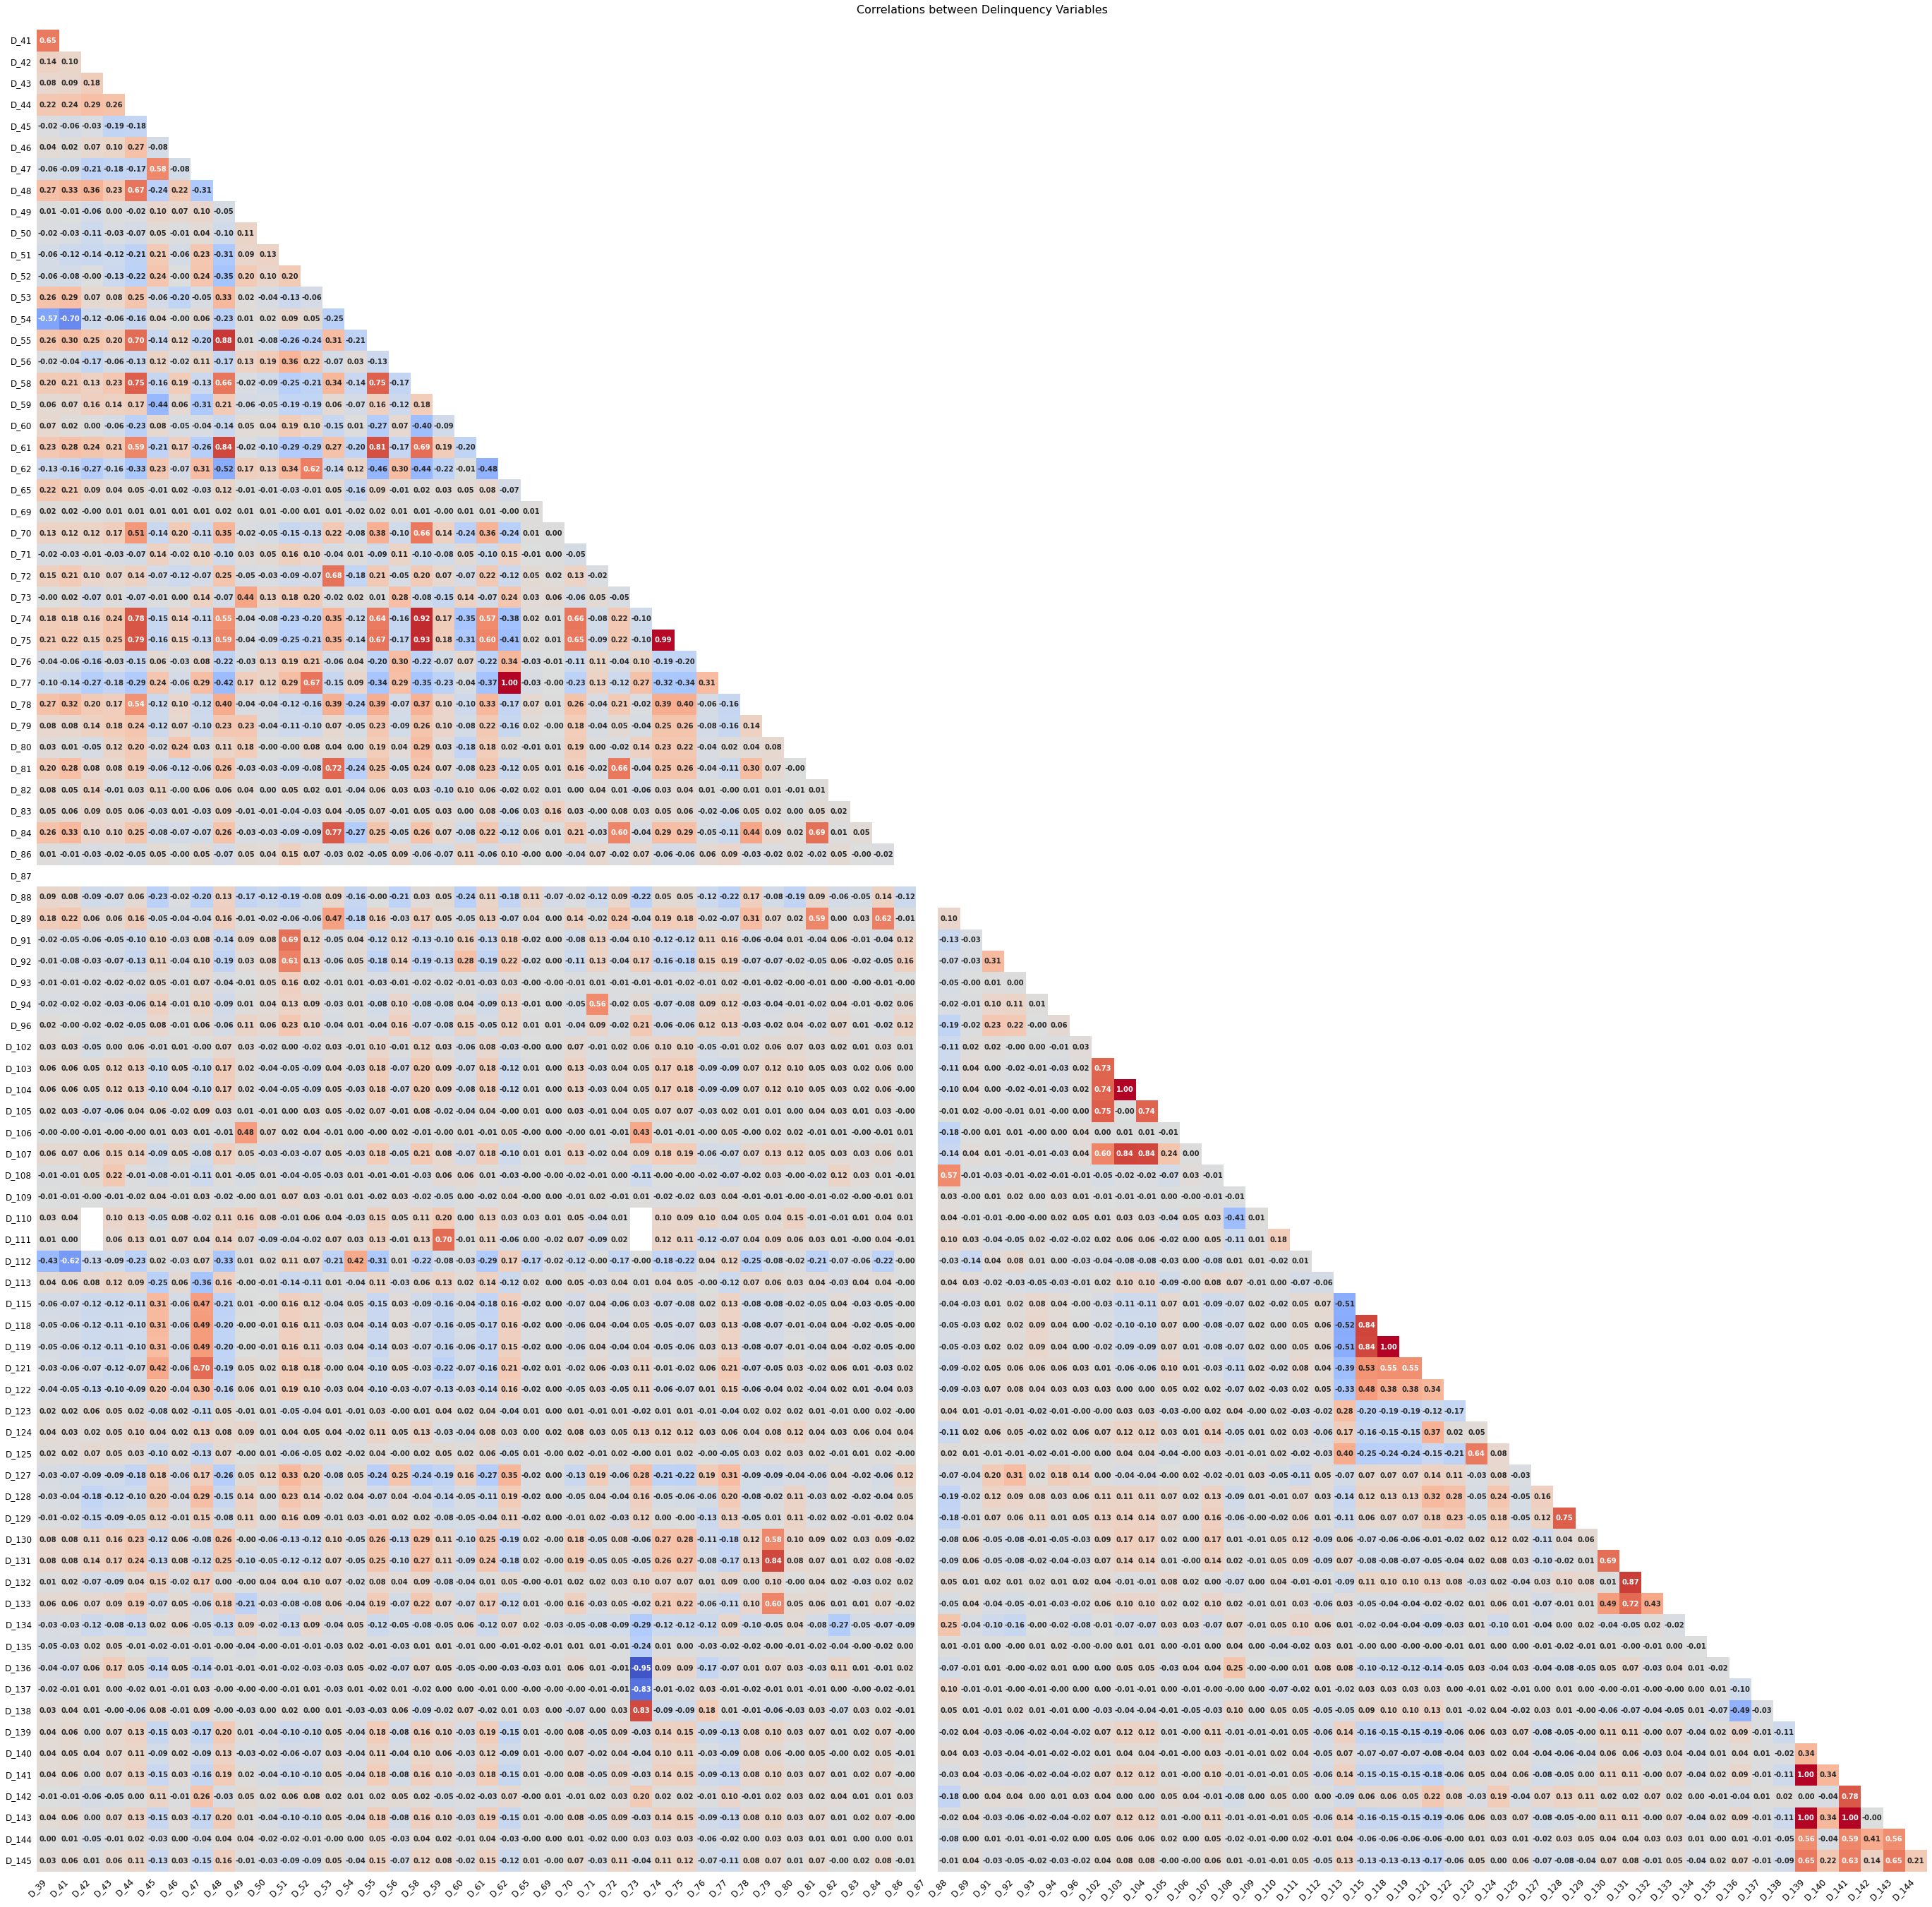

In [27]:
corr=plot_df.iloc[:,:-1].corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(48,48))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Delinquency Variables\n', fontsize=16)
fig.show()

- There are several highly correlated Delinquency variables, with a few pairs perfectly positively correlated at 1.0. We can use this as guidance in our imputation method by fitting linear regression models between both highly correlated features in order to impute the missing values in them
- There are also a number of missing correlations, particularly in Delinquency 87, due to high percentage of null values in this feature.

In [28]:
corr=plot_df.iloc[:,:-1].corr()
corr = corr

In [29]:
corr = corr.drop('D_87')

In [30]:
corr_positive = corr.abs()

In [31]:
corr_max = pd.DataFrame(corr_positive.T.apply(lambda x: x.nlargest(2).idxmin()))
corr_max.rename(columns={0:"Max_correlated"},inplace=True)

In [32]:
corr_max

,Max_correlated
D_39,D_41
D_41,D_54
D_42,D_48
D_43,D_44
D_44,D_75
...,...
D_141,D_139
D_142,D_141
D_143,D_139
D_144,D_141


In [33]:
corr_total = corr_max.join(corr)

In [34]:
corr_total

,Max_correlated,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,D_48,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
D_39,D_41,1.000000,0.645251,0.141653,0.083052,0.221466,-0.021187,0.041595,-0.056477,0.274725,...,-0.037946,-0.016497,0.033107,0.041733,0.040156,0.041280,-0.005532,0.041654,0.003376,0.032895
D_41,D_54,0.645251,1.000000,0.104153,0.087516,0.235284,-0.055082,0.019424,-0.085226,0.325085,...,-0.069049,-0.012846,0.040857,0.064142,0.054480,0.063164,-0.008683,0.064078,0.007380,0.055327
D_42,D_48,0.141653,0.104153,1.000000,0.175774,0.286109,-0.029070,0.070574,-0.210156,0.359389,...,0.057869,0.008928,0.010192,0.003391,0.042617,0.001497,-0.060457,0.003442,-0.054315,0.014647
D_43,D_44,0.083052,0.087516,0.175774,1.000000,0.260763,-0.187815,0.104044,-0.184568,0.231435,...,0.172514,0.003930,-0.004184,0.068396,0.065633,0.066162,-0.050034,0.068401,-0.009699,0.062997
D_44,D_75,0.221466,0.235284,0.286109,0.260763,1.000000,-0.178513,0.268303,-0.172985,0.666615,...,0.050345,-0.020202,-0.064735,0.131039,0.107050,0.129399,0.003508,0.131048,0.016412,0.113366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D_141,D_139,0.041280,0.063164,0.001497,0.066162,0.129399,-0.146524,0.029018,-0.161508,0.192704,...,0.087269,-0.010211,-0.108783,0.998100,0.338793,1.000000,0.778087,0.997739,0.586847,0.631688
D_142,D_141,-0.005532,-0.008683,-0.060457,-0.050034,0.003508,0.114593,-0.008849,0.256688,-0.033818,...,-0.038192,0.008779,0.021102,0.000096,-0.035448,0.778087,1.000000,-0.003927,0.409654,0.144606
D_143,D_139,0.041654,0.064078,0.003442,0.068401,0.131048,-0.149905,0.029553,-0.167165,0.195467,...,0.089655,-0.010349,-0.110864,0.999602,0.339395,0.997739,-0.003927,1.000000,0.559727,0.645316
D_144,D_141,0.003376,0.007380,-0.054315,-0.009699,0.016412,-0.034379,0.004172,-0.039270,0.036701,...,0.014949,-0.008278,-0.045820,0.560505,-0.040425,0.586847,0.409654,0.559727,1.000000,0.208631


In [35]:
corr_total["Corrlation_value"] = corr_total.apply(lambda x:x.loc[x.loc["Max_correlated"]],axis=1)

In [36]:
corr_total = corr_total[["Max_correlated","Corrlation_value"]].sort_values(by=["Corrlation_value"],ascending=False)

In [37]:
corr_total

,Max_correlated,Corrlation_value
D_62,D_77,0.999824
D_77,D_62,0.999824
D_104,D_103,0.999745
D_103,D_104,0.999745
D_143,D_139,0.999602
...,...,...
D_41,D_54,-0.704414
D_54,D_41,-0.704414
D_137,D_73,-0.826777
D_73,D_136,-0.953685


<AxesSubplot:xlabel='D_62', ylabel='D_77'>

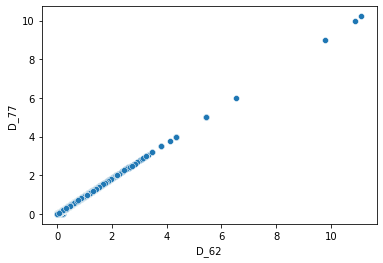

In [38]:
sns.scatterplot(train["D_62"],train["D_77"])

In [39]:
pd.DataFrame(train[train["D_77"].isnull()]["D_62"].value_counts()).sort_values("D_62",ascending=False)

,D_62
0.031860,86
0.032349,81
0.032898,81
0.032379,81
0.063354,80
...,...
0.000316,1
0.000397,1
0.001851,1
0.000760,1


In [40]:
train[(train["D_77"].isnull())&(train["D_62"].isnull())]["D_62"].count()

0

<AxesSubplot:xlabel='D_103', ylabel='D_104'>

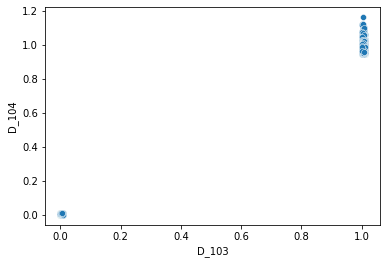

In [41]:
sns.scatterplot(train["D_103"],train["D_104"])

In [42]:
train["D_104"].value_counts()

0.956055    3426
0.955566    3364
0.957031    3354
0.955078    3332
0.954590    3283
            ... 
0.000079       1
0.000183       1
0.000028       1
0.000094       1
0.000055       1
Name: D_104, Length: 8130, dtype: int64

<AxesSubplot:xlabel='D_139', ylabel='D_143'>

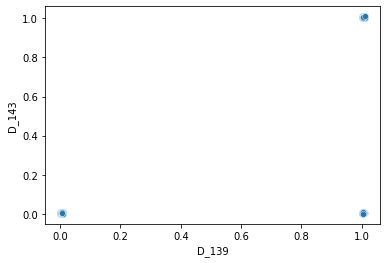

In [43]:
sns.scatterplot(train["D_139"],train["D_143"])

In [44]:
train["D_139"].value_counts()

1.005859e+00    7992
1.001953e+00    7952
1.004883e+00    7918
1.008789e+00    7890
1.000977e+00    7834
                ... 
9.536743e-07       1
6.824732e-05       1
9.322166e-05       1
9.471178e-05       1
1.147985e-04       1
Name: D_139, Length: 8258, dtype: int64

### <b><span >2.1.3 |</span><span > Analysis For spend Variables: </span></b>

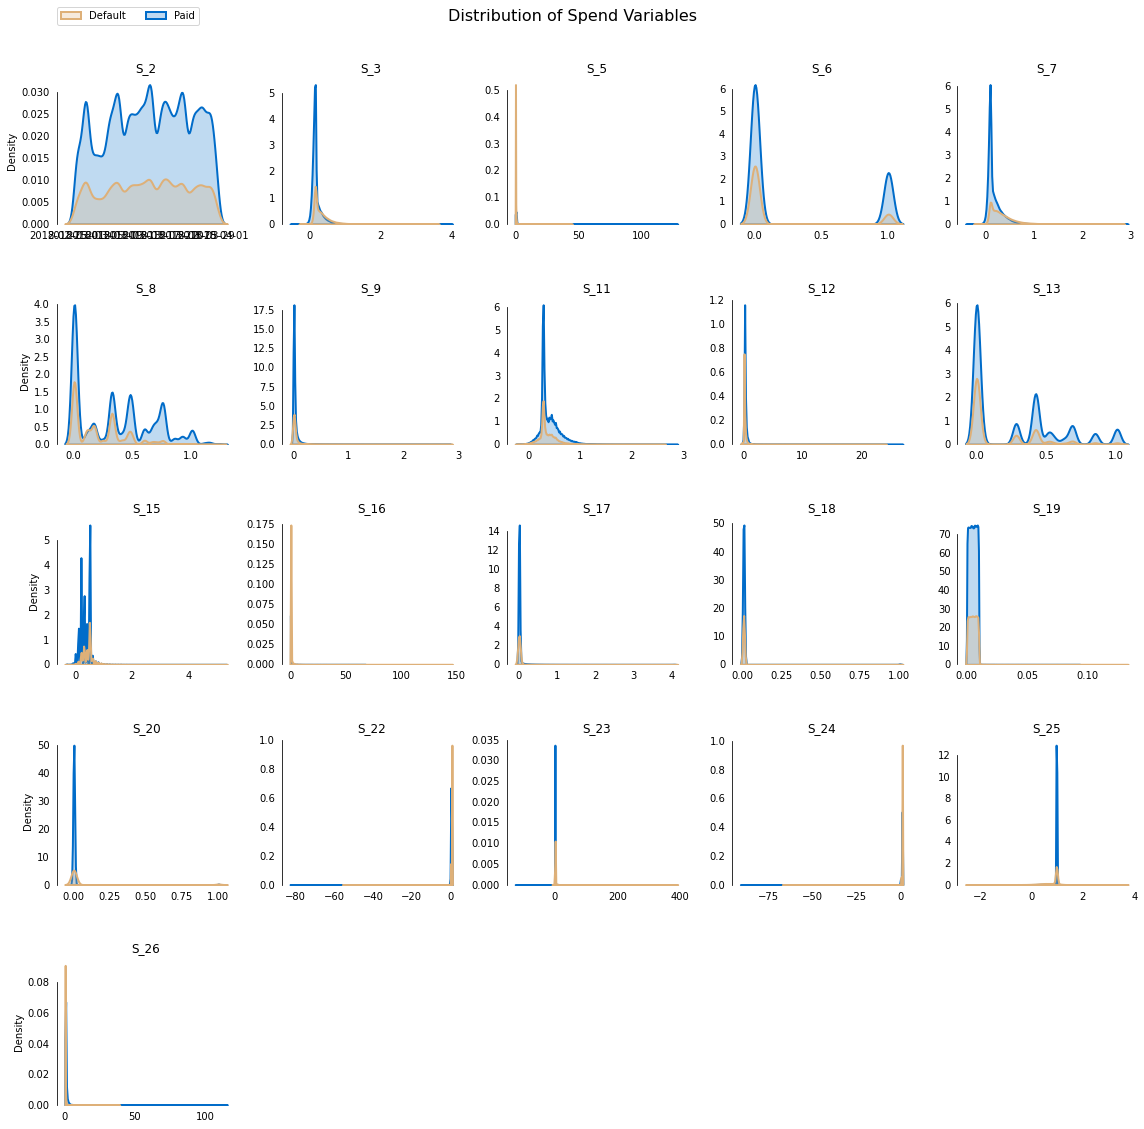

In [45]:
cols=[col for col in train.columns if (col.startswith(('S','t'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(5,5, figsize=(16,20))
fig.suptitle('Distribution of Spend Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*5
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(1,5):
    ax[4,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

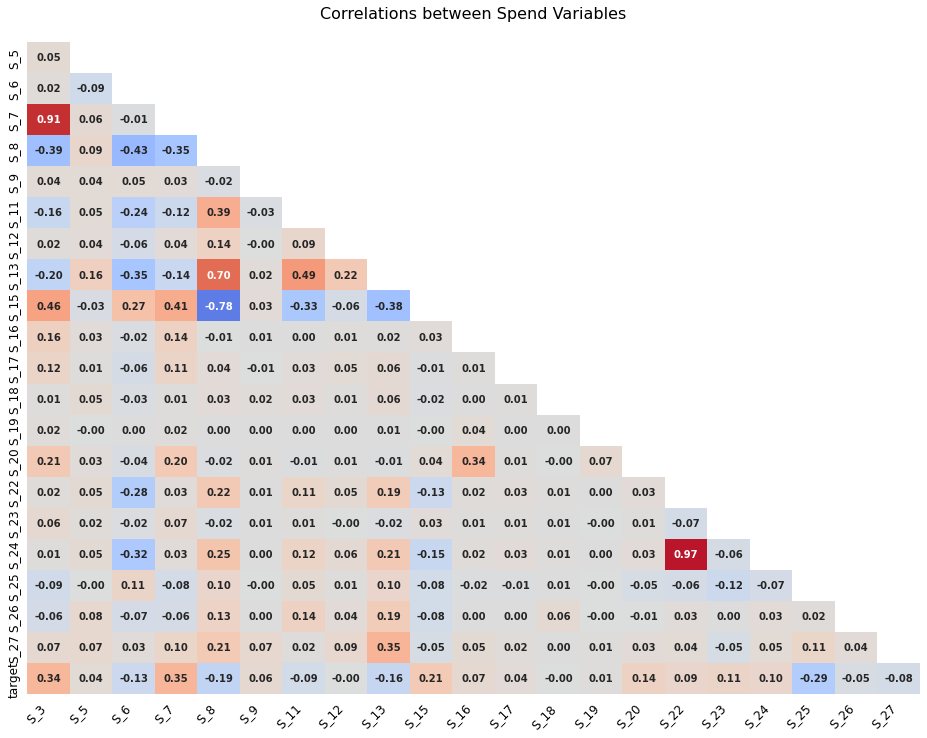

In [46]:
corr=plot_df.corr()
mask=np.triu(np.ones_like(corr, dtype=bool))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()
fig, ax = plt.subplots(figsize=(16,12))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Spend Variables\n', fontsize=16)
fig.show()

### <b><span >2.1.4 |</span><span > Analysis For Payment Variables: </span></b>

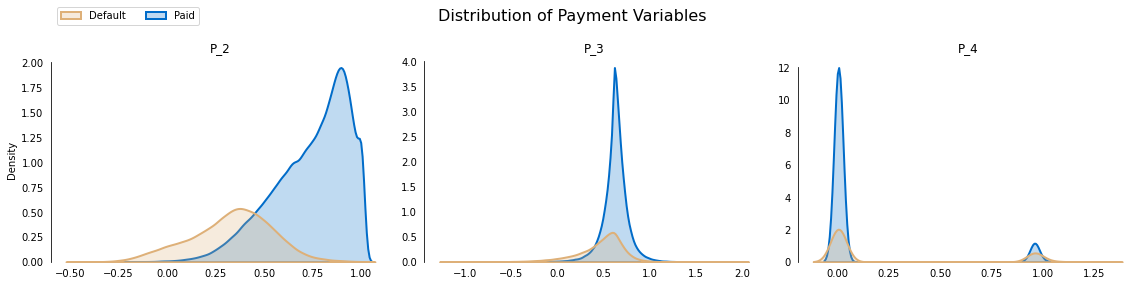

In [47]:
cols=[col for col in train.columns if (col.startswith(('P','t'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Distribution of Payment Variables',fontsize=16)
for i, col in enumerate(plot_df.columns[:-1]):
    sns.kdeplot(x=col, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[i])
    ax[i].tick_params(left=False,bottom=False)
    ax[i].set(title='{}'.format(col), xlabel='', ylabel=('Density' if i==0 else ''))
handles, _ = ax[0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 1))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

### <b><span >2.1.5 |</span><span > Analysis For Balance Variables: </span></b>

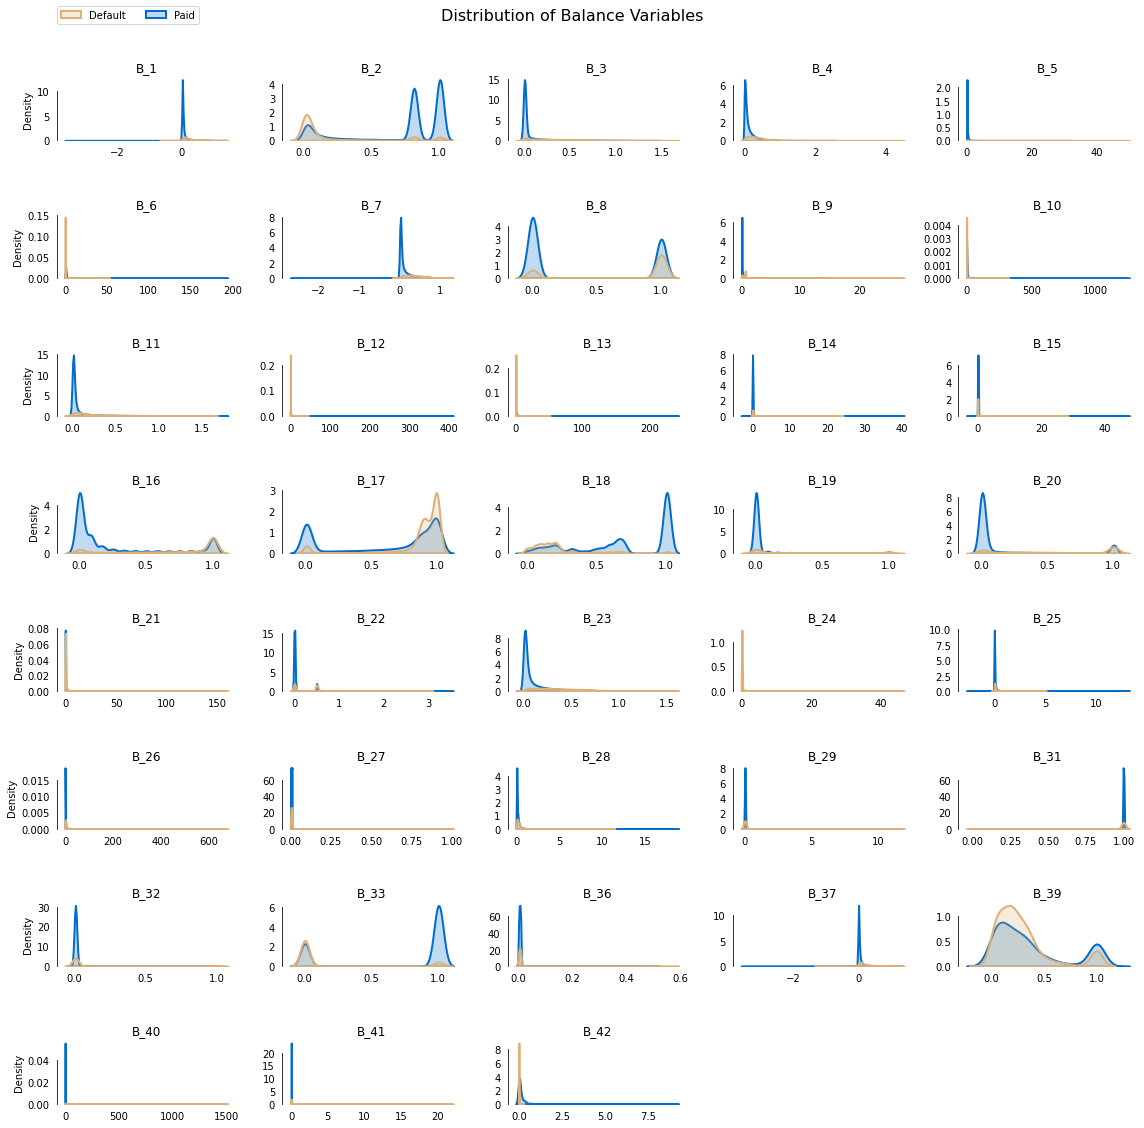

In [48]:
cols=[col for col in train.columns if (col.startswith(('B','t'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(8,5, figsize=(16,20))
fig.suptitle('Distribution of Balance Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*8
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(3,5):
    ax[7,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

### <b><span >2.1.6 |</span><span > Analysis For Risk Variables: </span></b>

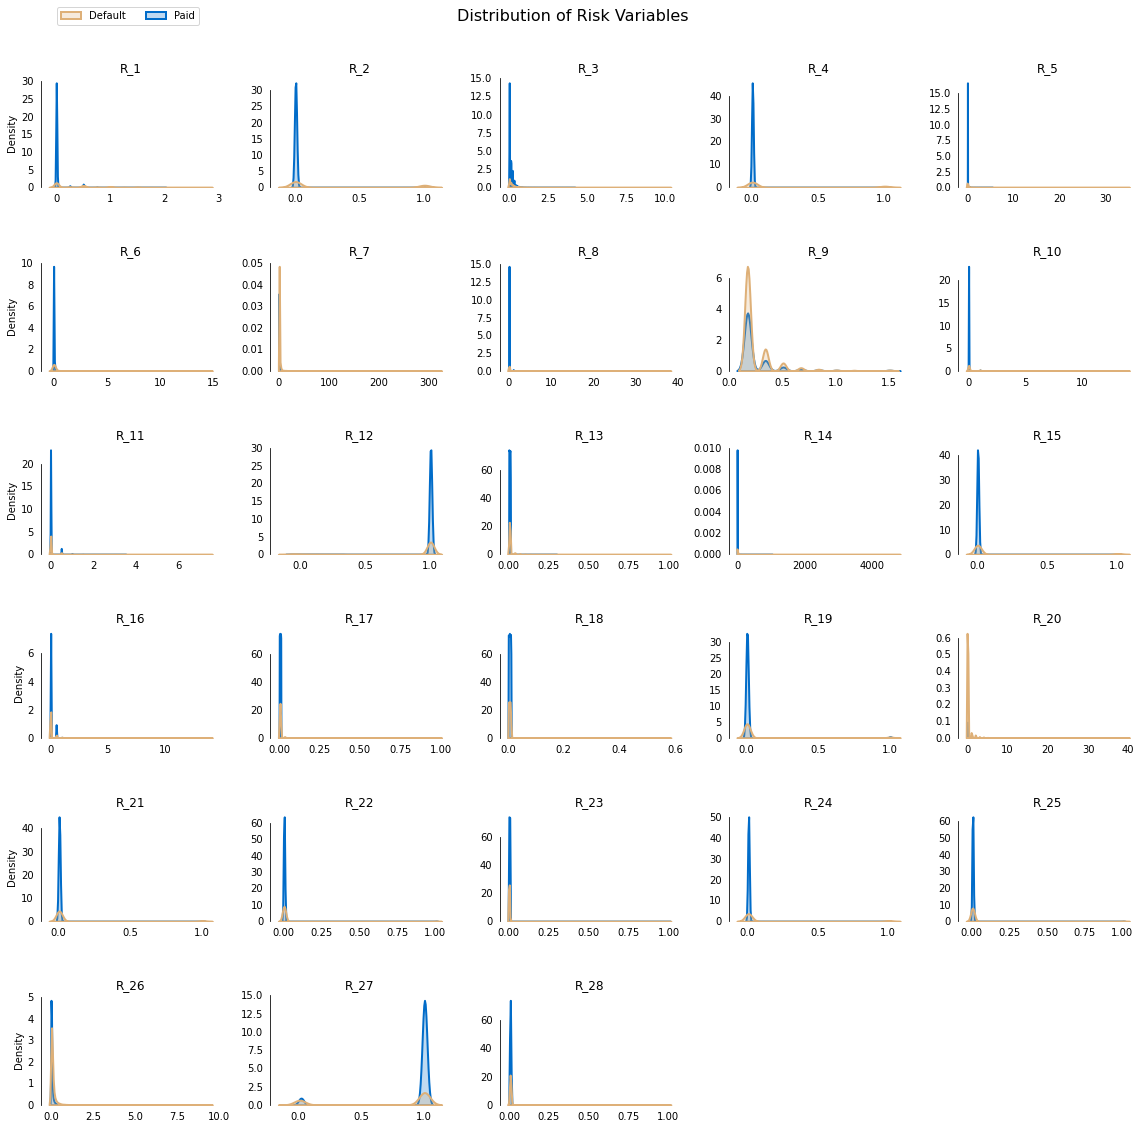

In [49]:
cols=[col for col in train.columns if (col.startswith(('R','t'))) & (col not in cat_cols[:-1])]
plot_df=train[cols]
fig, ax = plt.subplots(6,5, figsize=(16,20))
fig.suptitle('Distribution of Risk Variables',fontsize=16)
row=0
col=[0,1,2,3,4]*6
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%5==0):
        row+=1
    sns.kdeplot(x=column, hue='target', palette=pal[::-1], hue_order=[1,0], 
                label=['Default','Paid'], data=plot_df, 
                fill=True, linewidth=2, legend=False, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))
for i in range(3,5):
    ax[5,i].set_visible(False)
handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['Default','Paid'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.985))
sns.despine(bottom=True, trim=True)
plt.tight_layout(rect=[0, 0.2, 1, 0.99])

In [50]:
train["R_5"].value_counts()

0.502930    620
0.504395    618
0.508301    614
0.506348    608
0.500977    604
           ... 
0.000120      1
0.000077      1
0.000014      1
0.000092      1
0.000116      1
Name: R_5, Length: 8467, dtype: int64

### <b><span >2.1.7 |</span><span > Analysis For Categorical Variables: </span></b>

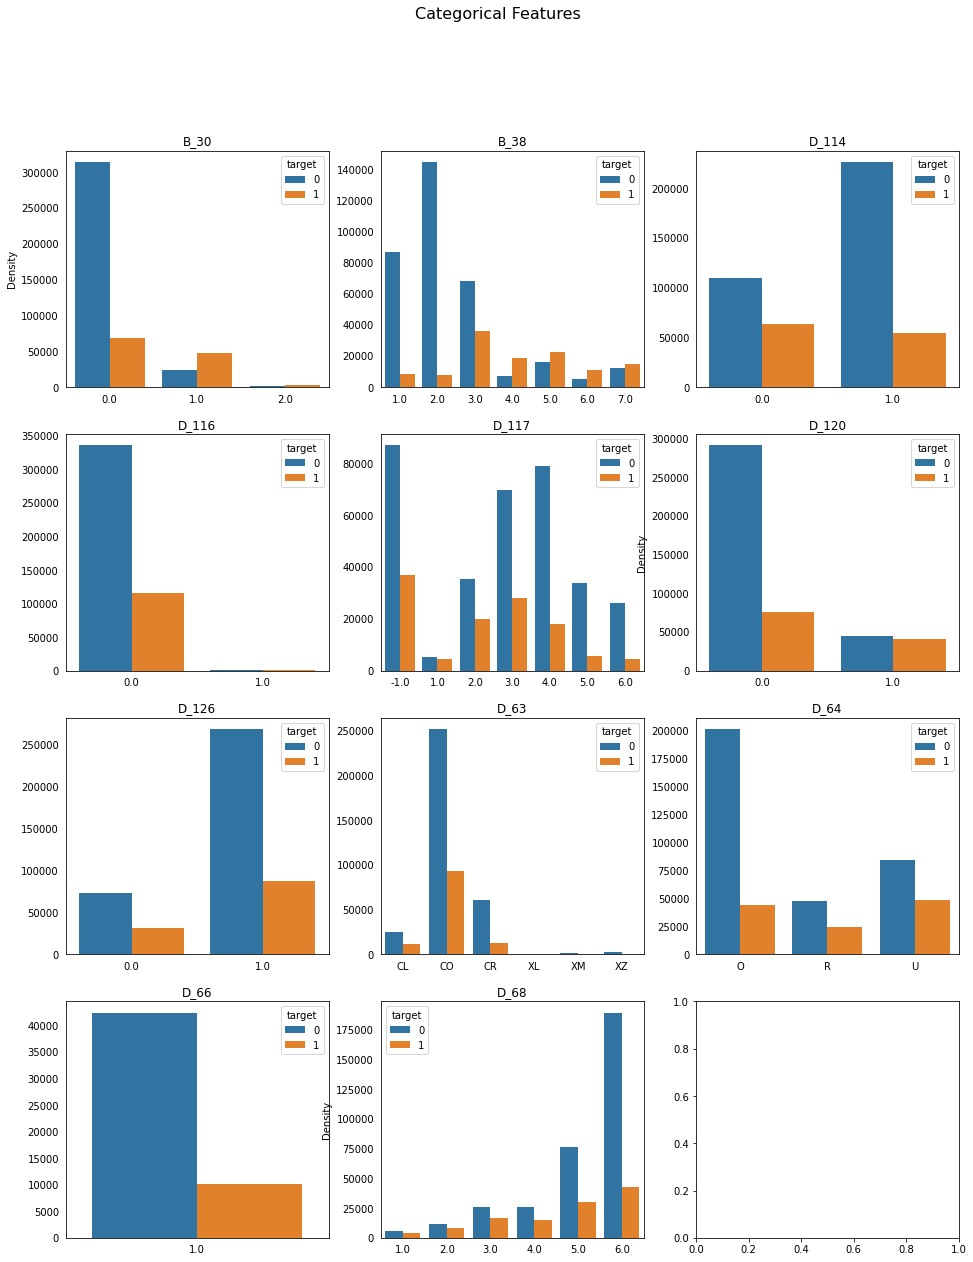

In [51]:
cols=cat_cols
plot_df=train[cols]
plot_df["target"] = train["target"]
fig, ax = plt.subplots(4,3, figsize=(16,20))
fig.suptitle('Categorical Features',fontsize=16)
row=0
col=[0,1,2]*4
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%3==0):
        row+=1
    plot_df[column]=plot_df[column].astype(object)
    df=pd.DataFrame(plot_df.groupby(column)['target'].value_counts().rename('count').reset_index().replace('',np.nan))
    sns.barplot(x=column,y="count", hue='target', data=df, 
                fill=True, linewidth=2, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))



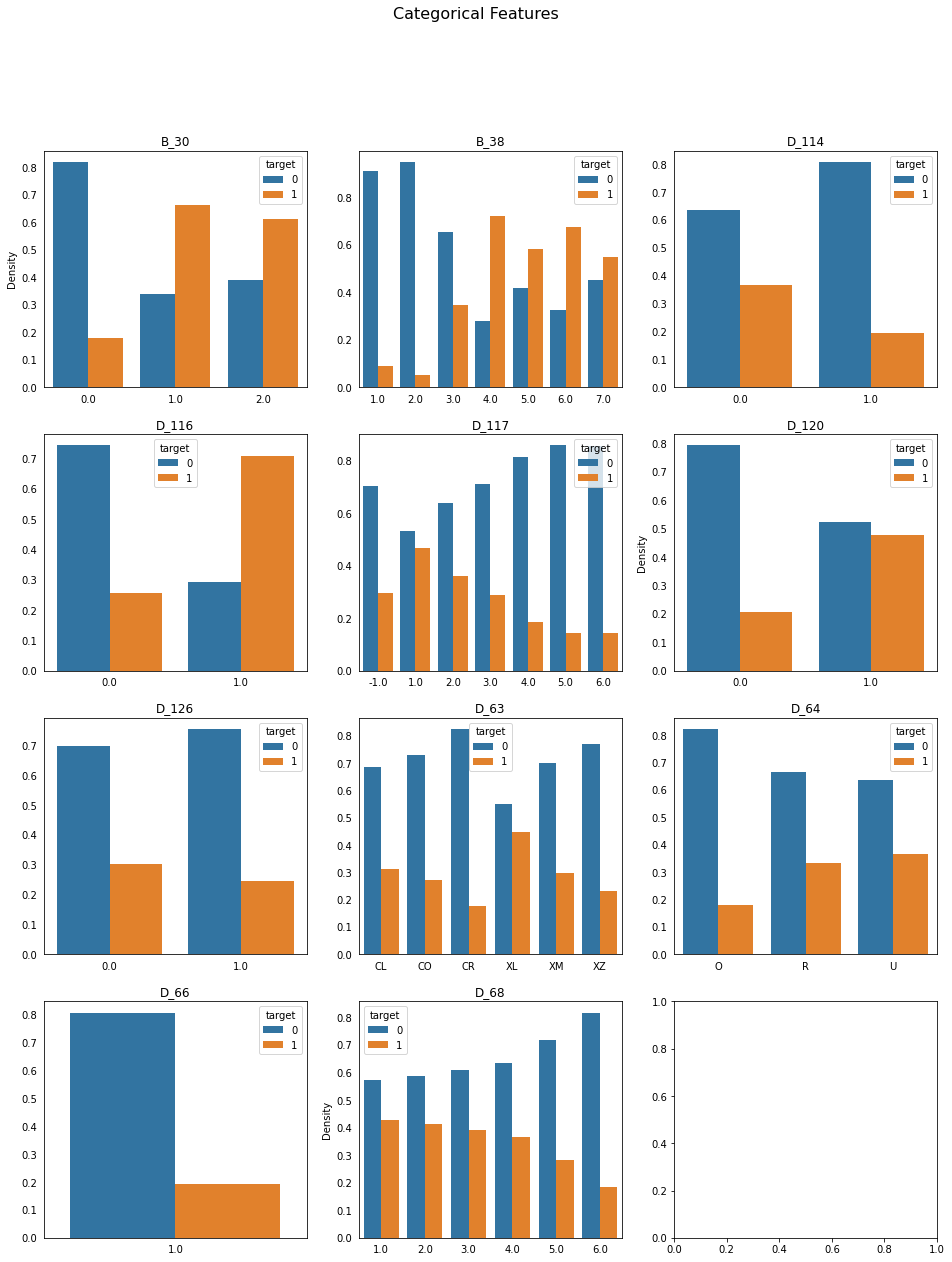

In [52]:
cols=cat_cols
plot_df=train[cols]
plot_df["target"] = train["target"]
fig, ax = plt.subplots(4,3, figsize=(16,20))
fig.suptitle('Categorical Features',fontsize=16)
row=0
col=[0,1,2]*4
for i, column in enumerate(plot_df.columns[:-1]):
    if (i!=0)&(i%3==0):
        row+=1
    plot_df[column]=plot_df[column].astype(object)
    df=pd.DataFrame(plot_df.groupby(column)['target'].value_counts(normalize=True).rename('count').reset_index().replace('',np.nan))
    sns.barplot(x=column,y="count", hue='target', data=df, 
                fill=True, linewidth=2, ax=ax[row,col[i]])
    ax[row,col[i]].tick_params(left=False,bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%5==0 else ''))


# <b><span >2.2 |</span><span > Handling Missing Data </span></b>

In [53]:
null_train=round((train.isna().sum()/train.shape[0]*100),2).sort_values(ascending=False)
null_train=null_train.to_frame().rename(columns={0:'Missing %'})


In [54]:
null_test=round((test.isna().sum()/test.shape[0]*100),2).sort_values(ascending=False)
null_test=null_test.to_frame().rename(columns={0:'Missing %'})


In [55]:
null_train[null_train["Missing %"]>=30]

,Missing %
D_87,99.86
D_88,99.82
D_108,99.43
D_111,99.20
D_110,99.20
B_39,99.11
D_73,99.08
B_42,98.66
D_137,96.43
D_134,96.43


In [56]:
null_train[null_train["Missing %"]>=30].count()

Missing %    31
dtype: int64

In [57]:
null_train.count()

Missing %    190
dtype: int64

In [58]:
null_train[null_train["Missing %"]==0].count()

Missing %    82
dtype: int64

## <b><span >2.2.1 |</span><span > Drop columns containing null values </span></b>

In [59]:
null_train[null_train["Missing %"]==0]

,Missing %
D_96,0.0
S_26,0.0
D_102,0.0
R_25,0.0
S_2,0.0
...,...
B_24,0.0
D_75,0.0
P_4,0.0
B_23,0.0


In [60]:
non_null_train_list = list(null_train[null_train["Missing %"]==0].index)

In [61]:
non_null_test_list = list(null_test[null_test["Missing %"]==0].index)

In [62]:
variables_considered = [x for x in non_null_train_list if x in non_null_test_list]

In [63]:
len(variables_considered)

74

In [64]:
variables_considered = [x for x in variables_considered if x!="S_2"]

In [65]:
train[variables_considered].info()

<class 'pandas.core.frame.DataFrame'>
Index: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   D_96    458913 non-null  float16 
 1   D_102   458913 non-null  float16 
 2   R_25    458913 non-null  float16 
 3   B_36    458913 non-null  float16 
 4   D_94    458913 non-null  float16 
 5   D_126   458913 non-null  category
 6   D_127   458913 non-null  float16 
 7   D_133   458913 non-null  float16 
 8   R_28    458913 non-null  float16 
 9   D_140   458913 non-null  float16 
 10  D_144   458913 non-null  float16 
 11  R_24    458913 non-null  float16 
 12  R_12    458913 non-null  float16 
 13  D_93    458913 non-null  float16 
 14  D_92    458913 non-null  float16 
 15  R_6     458913 non-null  float16 
 16  B_18    458913 non-null  float16 
 17  D_65    458913 non-null  fl

In [66]:
cat_var_considered = [ x for x in cat_cols if x in variables_considered]

In [67]:
len(cat_var_considered)

3

In [68]:
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

In [69]:
from sklearn.metrics import make_scorer

In [70]:
amex_score = make_scorer(amex_metric,needs_proba=True,greater_is_better=True)

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [72]:

for cat_col in cat_var_considered:
    encoder = LabelEncoder()
    train[cat_col] = encoder.fit_transform(train[cat_col])
    test[cat_col] = encoder.transform(test[cat_col])

In [73]:
X = train[variables_considered]
y = train["target"]

In [74]:
results_val_df = pd.DataFrame(columns=["C","penalty","fit_intercept",
                                       "cross_val_score","mean_val_score"])

In [75]:
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
y_oof = np.zeros(X.shape[0])
penalties = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
fit_intercepts = [True,False]
#y_test = np.zeros(test.shape[0])
ix = 0
for c in c_values:
    for penalty in penalties:
        for fit_intercet_value in fit_intercepts:
            print(ix)
            val_scores = []
            folds_number = 0
            for train_ind, val_ind in skf.split(X, y):
                
                print(f"******* Fold {folds_number} ******* ")
                tr_x, val_x = (
                    X.iloc[train_ind].reset_index(drop=True),
                    X.iloc[val_ind].reset_index(drop=True),
                )
                tr_y, val_y = (
                    y.iloc[train_ind].reset_index(drop=True),
                    y.iloc[val_ind].reset_index(drop=True),
                )

                clf = LogisticRegression(solver = "lbfgs",C=c,penalty=penalty,fit_intercept=fit_intercet_value)
                clf.fit(tr_x, tr_y)
                preds = clf.predict_proba(val_x)[:, 1]
                val_score = amex_metric(val_y, preds)
                print(f"For Fold {folds_number},Val_score ={val_score}")
                val_scores.append(val_score)
                folds_number+=1
            
            results_val_df.loc[ix,"C"] = c
            results_val_df.loc[ix,"penalty"] = penalty
            results_val_df.loc[ix,"fit_intercept"] = fit_intercet_value
            results_val_df.iloc[ix]["cross_val_score"] = val_scores
            results_val_df.loc[ix,"mean_val_score"] = np.mean(val_scores)
            ix+=1
            
            
            
                


0
******* Fold 0 ******* 
For Fold 0,Val_score =0.727255006574425
******* Fold 1 ******* 
For Fold 1,Val_score =0.7212451261332351
******* Fold 2 ******* 
For Fold 2,Val_score =0.7223894737898329
******* Fold 3 ******* 
For Fold 3,Val_score =0.7186116078950451
******* Fold 4 ******* 
For Fold 4,Val_score =0.7249751338593752
1
******* Fold 0 ******* 
For Fold 0,Val_score =0.7273676999022642
******* Fold 1 ******* 
For Fold 1,Val_score =0.7206075479931946
******* Fold 2 ******* 
For Fold 2,Val_score =0.7224298613659655
******* Fold 3 ******* 
For Fold 3,Val_score =0.718407965317529
******* Fold 4 ******* 
For Fold 4,Val_score =0.7245139307990649
2
******* Fold 0 ******* 
For Fold 0,Val_score =0.7267576061610761
******* Fold 1 ******* 
For Fold 1,Val_score =0.7213448385207621
******* Fold 2 ******* 
For Fold 2,Val_score =0.7218836092531649
******* Fold 3 ******* 
For Fold 3,Val_score =0.7193352751475084
******* Fold 4 ******* 
For Fold 4,Val_score =0.7247183670328146
3
******* Fold 0 ****

In [76]:
results_val_df.sort_values(by=["mean_val_score"],ascending=False)

,C,penalty,fit_intercept,cross_val_score,mean_val_score
4,1.0,l2,True,"[0.7270554746529623, 0.7215547609856597, 0.722...",0.723065
0,100,l2,True,"[0.727255006574425, 0.7212451261332351, 0.7223...",0.722895
2,10,l2,True,"[0.7267576061610761, 0.7213448385207621, 0.721...",0.722808
6,0.1,l2,True,"[0.7270182138071579, 0.7209226588737174, 0.722...",0.722774
5,1.0,l2,False,"[0.7270415505859773, 0.7208498546481814, 0.722...",0.722678
1,100,l2,False,"[0.7273676999022642, 0.7206075479931946, 0.722...",0.722665
7,0.1,l2,False,"[0.7272039311389926, 0.7208558596681922, 0.722...",0.722481
3,10,l2,False,"[0.7271397436747937, 0.7203718334810298, 0.722...",0.722459
8,0.01,l2,True,"[0.7261998501518052, 0.720588940615158, 0.7222...",0.722154
9,0.01,l2,False,"[0.726085599416207, 0.7196244802029537, 0.7225...",0.721853


## Xgboost Classifier:

In [77]:
import xgboost as xgb

In [78]:
booster_values = ["gbtree"]
depth_values = [3,5,7]
estimator_values = [100,150,200]
colsample_bytree = [0.3,0.5,0.7]
reg_lambda_values = [0.3,0.5]


In [79]:
results_val_df_xgboost = pd.DataFrame(columns=["Booster","depth","Estimator",
                                       "col_sample_by_tree","reg_lambda",
                                        "cross_val_score","mean_val_score"])

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
N_FOLDS = 2
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
y_oof = np.zeros(X.shape[0])

#y_test = np.zeros(test.shape[0])
ix = 0
for booster_value in booster_values:
    for depth in depth_values:
        for estimator in estimator_values:
            for col_bytree in colsample_bytree:
                for reg_lam_value in reg_lambda_values:
                    print(ix)
                    val_scores = []
                    folds_number = 0
                    for train_ind, val_ind in skf.split(X, y):

                        print(f"******* Fold {folds_number} ******* ")
                        tr_x, val_x = (
                            X.iloc[train_ind].reset_index(drop=True),
                            X.iloc[val_ind].reset_index(drop=True),
                        )
                        tr_y, val_y = (
                            y.iloc[train_ind].reset_index(drop=True),
                            y.iloc[val_ind].reset_index(drop=True),
                        )
                        X_train, X_test, y_train, y_true = train_test_split(tr_x, tr_y, stratify=tr_y,test_size=0.2, random_state=42)

                        clf = xgb.XGBClassifier(n_estimators=estimator,
                                                max_depth=depth,
                                                colsample_bytree=col_bytree,
                                                booster=booster_value,
                                                reg_lambda=reg_lam_value,reg_alpha=0.2,
                                                early_stopping_rounds=60,objective="binary:logistic",
                                           n_jobs=-1)
                        eval_set = [(X_test, y_true)]
                        clf.fit(tr_x, tr_y,eval_set=eval_set,verbose=0)
                        preds = clf.predict_proba(val_x)[:, 1]
                        val_score = amex_metric(val_y, preds)
                        print(f"For Fold {folds_number},Val_score ={val_score}")
                        val_scores.append(val_score)
                        folds_number+=1

                    results_val_df_xgboost.loc[ix,"Booster"] = booster_value
                    results_val_df_xgboost.loc[ix,"depth"] = depth
                    results_val_df_xgboost.loc[ix,"Estimator"] = estimator
                    results_val_df_xgboost.loc[ix,"col_sample_by_tree"] = col_bytree
                    results_val_df_xgboost.loc[ix,"reg_lambda"] = reg_lam_value
                    results_val_df_xgboost.iloc[ix]["cross_val_score"] = val_scores
                    results_val_df_xgboost.loc[ix,"mean_val_score"] = np.mean(val_scores)
                    ix+=1

0
******* Fold 0 ******* 
For Fold 0,Val_score =0.7399155233300841
******* Fold 1 ******* 
For Fold 1,Val_score =0.7379149854865528
1
******* Fold 0 ******* 
For Fold 0,Val_score =0.7404607864746959
******* Fold 1 ******* 
For Fold 1,Val_score =0.7389593142123588
2
******* Fold 0 ******* 
For Fold 0,Val_score =0.7410427696636022
******* Fold 1 ******* 
For Fold 1,Val_score =0.7394560356462161
3
******* Fold 0 ******* 
For Fold 0,Val_score =0.7411527049927962
******* Fold 1 ******* 
For Fold 1,Val_score =0.7388596503030318
4
******* Fold 0 ******* 
For Fold 0,Val_score =0.7398197834327158
******* Fold 1 ******* 
For Fold 1,Val_score =0.7394551632963486
5
******* Fold 0 ******* 
For Fold 0,Val_score =0.740337793581376
******* Fold 1 ******* 
For Fold 1,Val_score =0.7389733056335908
6
******* Fold 0 ******* 
For Fold 0,Val_score =0.7408645178931056
******* Fold 1 ******* 
For Fold 1,Val_score =0.7393253305157212
7
******* Fold 0 ******* 
For Fold 0,Val_score =0.7409535603135591
******* Fo

In [82]:
results_val_df_xgboost.sort_values(by=["mean_val_score"],ascending=False)

,Booster,depth,Estimator,col_sample_by_tree,reg_lambda,cross_val_score,mean_val_score
17,gbtree,3,200,0.7,0.5,"[0.7417342099350284, 0.7419279498092073]",0.741831
14,gbtree,3,200,0.5,0.3,"[0.7420551965491021, 0.7415596812899001]",0.741807
13,gbtree,3,200,0.3,0.5,"[0.7414491315459686, 0.7416389810435133]",0.741544
11,gbtree,3,150,0.7,0.5,"[0.7415743716969747, 0.7408476275815387]",0.741211
9,gbtree,3,150,0.5,0.5,"[0.7412178551560369, 0.7411267918889457]",0.741172
8,gbtree,3,150,0.5,0.3,"[0.7414002314834229, 0.7406179032914485]",0.741009
16,gbtree,3,200,0.7,0.3,"[0.7407228258286507, 0.741113270100497]",0.740918
7,gbtree,3,150,0.3,0.5,"[0.7409535603135591, 0.7408150926316059]",0.740884
15,gbtree,3,200,0.5,0.5,"[0.7406240608169842, 0.740726775719398]",0.740675
10,gbtree,3,150,0.7,0.3,"[0.7405203170190415, 0.7404107461867098]",0.740466


In [83]:
#X_test = test[variables_considered]

In [84]:
#X_test["D_126"] = X_test["D_126"].apply(lambda x: int(x))


In [85]:
#X_test = X_test.fillna(0)

In [86]:
#model.fit(X,y)

In [87]:
#y_pred = model.predict_proba(X_test)[:,1]

In [88]:
#y_pred

In [89]:
#plt.hist(y_pred)

In [90]:
#customers = test.index
#submission_df = pd.DataFrame(index=customers,data={'prediction':y_pred})

In [91]:
#submission_df.head()

In [92]:
#submission_df = submission_df.reset_index()

## <b><span >2.2.3 |</span><span > Iterative Imputer </span></b>

In [93]:
from sklearn.experimental import enable_iterative_imputer #MUST IMPORT THIS
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



In [94]:
corr_target["target"] = corr_target["target"].apply(lambda x:np.abs(x))

In [95]:
corr_target.sort_values(by="target",ascending=False)[:11].index

Index(['P_2', 'D_48', 'B_2', 'B_18', 'D_55', 'B_9', 'D_61', 'D_44', 'B_33',
       'B_3', 'B_7'],
      dtype='object')

In [96]:
corr_target.sort_values(by="target",ascending=False)[:30]

,target
P_2,0.667292
D_48,0.612357
B_2,0.557697
B_18,0.546276
D_55,0.540676
B_9,0.540564
D_61,0.534542
D_44,0.530538
B_33,0.520652
B_3,0.506834


In [97]:
additional_features = list(corr_target.sort_values(by="target",ascending=False)[:15].index)

In [98]:
null_train.loc[additional_features]

,Missing %
P_2,0.65
D_48,12.64
B_2,0.01
B_18,0.00
D_55,6.62
B_9,0.00
D_61,10.54
D_44,4.86
B_33,0.01
B_3,0.01


In [99]:
#removed_features = ["D_48","D_61","D_44","D_61","D_44"]

In [100]:
total_features_required = additional_features+variables_considered

In [101]:
#total_features_required = [x for x in total_features_required if x not in removed_features]

In [102]:
total_features_set = list(set(total_features_required))

In [103]:
X_train = train[total_features_set].copy().values#Matrix of Values
y_train = train["target"].copy()

In [104]:
X_test = test[total_features_set].copy().values

In [105]:
imputer = IterativeImputer(random_state=42, 
                           estimator= RandomForestRegressor(n_estimators=15,
                                                            max_depth=10,
                                                            bootstrap=True,
                                                            max_samples=0.5,
                                                            n_jobs=-1,
                                                            random_state=42
    ),
                          imputation_order="descending",
                          initial_strategy="most_frequent",
                          skip_complete="True")
imputer.fit(X_train)


IterativeImputer(estimator=RandomForestRegressor(max_depth=10, max_samples=0.5,
                                                 n_estimators=15, n_jobs=-1,
                                                 random_state=42),
                 imputation_order='descending',
                 initial_strategy='most_frequent', random_state=42,
                 skip_complete='True')

In [106]:
transformed_test = imputer.transform(X_test)

In [107]:
transformed_train = imputer.transform(X_train)

In [108]:
temp_train_df = pd.DataFrame(np.column_stack(list(zip(*transformed_train))), columns=total_features_set)

In [109]:
#Temporarily Store
temp_test_df = pd.DataFrame(np.column_stack(list(zip(*transformed_test))), columns=total_features_set)

In [110]:
#temp_train_df = pd.DataFrame(np.column_stack(list(zip(*transformed_train))), columns=total_features_set)

In [111]:
results_val_df_Imputed = pd.DataFrame(columns=["C","penalty","fit_intercept",
                                       "cross_val_score","mean_val_score"])

In [112]:
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
y_oof = np.zeros(X.shape[0])
penalties = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
fit_intercepts = [True,False]
#y_test = np.zeros(test.shape[0])
ix = 0
for c in c_values:
    for penalty in penalties:
        for fit_intercet_value in fit_intercepts:
            print(ix)
            val_scores = []
            folds_number = 0
            for train_ind, val_ind in skf.split(temp_train_df, y_train):
                
                print(f"******* Fold {folds_number} ******* ")
                tr_x, val_x = (
                    temp_train_df.iloc[train_ind].reset_index(drop=True),
                    temp_train_df.iloc[val_ind].reset_index(drop=True),
                )
                tr_y, val_y = (
                    y_train.iloc[train_ind].reset_index(drop=True),
                    y_train.iloc[val_ind].reset_index(drop=True),
                )

                clf = LogisticRegression(solver = "lbfgs",C=c,penalty=penalty,fit_intercept=fit_intercet_value)
                clf.fit(tr_x, tr_y)
                preds = clf.predict_proba(val_x)[:, 1]
                val_score = amex_metric(val_y, preds)
                print(f"For Fold {folds_number},Val_score ={val_score}")
                val_scores.append(val_score)
                folds_number+=1
            
            results_val_df_Imputed.loc[ix,"C"] = c
            results_val_df_Imputed.loc[ix,"penalty"] = penalty
            results_val_df_Imputed.loc[ix,"fit_intercept"] = fit_intercet_value
            results_val_df_Imputed.iloc[ix]["cross_val_score"] = val_scores
            results_val_df_Imputed.loc[ix,"mean_val_score"] = np.mean(val_scores)
            ix+=1
            
            
            

0
******* Fold 0 ******* 
For Fold 0,Val_score =0.7582274852423334
******* Fold 1 ******* 
For Fold 1,Val_score =0.7473622282248069
******* Fold 2 ******* 
For Fold 2,Val_score =0.7517070097322744
******* Fold 3 ******* 
For Fold 3,Val_score =0.7462480321280534
******* Fold 4 ******* 
For Fold 4,Val_score =0.7509025928917976
1
******* Fold 0 ******* 
For Fold 0,Val_score =0.7584067779780663
******* Fold 1 ******* 
For Fold 1,Val_score =0.7474541978344631
******* Fold 2 ******* 
For Fold 2,Val_score =0.7521847914478108
******* Fold 3 ******* 
For Fold 3,Val_score =0.7463885542617559
******* Fold 4 ******* 
For Fold 4,Val_score =0.7509732975057046
2
******* Fold 0 ******* 
For Fold 0,Val_score =0.7584783599508192
******* Fold 1 ******* 
For Fold 1,Val_score =0.7474565121368559
******* Fold 2 ******* 
For Fold 2,Val_score =0.7521197935551522
******* Fold 3 ******* 
For Fold 3,Val_score =0.7458935951775012
******* Fold 4 ******* 
For Fold 4,Val_score =0.7506907790171835
3
******* Fold 0 **

In [113]:
results_val_df_Imputed.sort_values(by=["mean_val_score"],ascending=False)

,C,penalty,fit_intercept,cross_val_score,mean_val_score
1,100,l2,False,"[0.7584067779780663, 0.7474541978344631, 0.752...",0.751082
3,10,l2,False,"[0.7584035734436828, 0.7476998661153438, 0.751...",0.750995
4,1.0,l2,True,"[0.75809502979661, 0.7475099991229774, 0.75199...",0.750974
7,0.1,l2,False,"[0.75834230406673, 0.7471228006832483, 0.75221...",0.750956
6,0.1,l2,True,"[0.7582749634966515, 0.746940623245887, 0.7518...",0.750954
2,10,l2,True,"[0.7584783599508192, 0.7474565121368559, 0.752...",0.750928
0,100,l2,True,"[0.7582274852423334, 0.7473622282248069, 0.751...",0.750889
5,1.0,l2,False,"[0.7582367344301995, 0.7467294381325222, 0.752...",0.750745
8,0.01,l2,True,"[0.7574076901750397, 0.7461641200064417, 0.751...",0.750353
9,0.01,l2,False,"[0.7575276541619601, 0.74607897326884, 0.75070...",0.750235


In [114]:
temp_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Data columns (total 81 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   B_28    458913 non-null  float64
 1   S_6     458913 non-null  float64
 2   R_23    458913 non-null  float64
 3   D_47    458913 non-null  float64
 4   R_15    458913 non-null  float64
 5   R_11    458913 non-null  float64
 6   R_10    458913 non-null  float64
 7   B_2     458913 non-null  float64
 8   P_4     458913 non-null  float64
 9   R_20    458913 non-null  float64
 10  D_144   458913 non-null  float64
 11  D_58    458913 non-null  float64
 12  S_19    458913 non-null  float64
 13  B_5     458913 non-null  float64
 14  D_75    458913 non-null  float64
 15  R_25    458913 non-null  float64
 16  B_18    458913 non-null  float64
 17  S_15    458913 non-null  float64
 18  D_60    458913 non-null  float64
 19  B_33    458913 non-null  float64
 20  R_2     458913 non-null  float64
 21  D_61    45

In [115]:
results_val_df_xgboost_imputed = pd.DataFrame(columns=["Booster","depth","Estimator",
                                       "col_sample_by_tree","reg_lambda",
                                        "cross_val_score","mean_val_score"])

In [116]:
N_FOLDS = 2
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
#y_oof = np.zeros(temp_train_df.shape[0])

#y_test = np.zeros(test.shape[0])
ix = 0
for booster_value in booster_values:
    for depth in depth_values:
        for estimator in estimator_values:
            for col_bytree in colsample_bytree:
                for reg_lam_value in reg_lambda_values:
                    print(ix)
                    val_scores = []
                    folds_number = 0
                    for train_ind, val_ind in skf.split(temp_train_df, y_train):

                        print(f"******* Fold {folds_number} ******* ")
                        
                        tr_x, val_x = (
                            temp_train_df.iloc[train_ind].reset_index(drop=True),
                            temp_train_df.iloc[val_ind].reset_index(drop=True),
                        )
                        tr_y, val_y = (
                            y_train.iloc[train_ind].reset_index(drop=True),
                            y_train.iloc[val_ind].reset_index(drop=True),
                        )
                        X_train, X_test, y_tr, y_true = train_test_split(tr_x, tr_y, stratify=tr_y,test_size=0.2, random_state=42)

                        clf = xgb.XGBClassifier(n_estimators=estimator,
                                                max_depth=depth,
                                                colsample_bytree=col_bytree,
                                                booster=booster_value,
                                                reg_lambda=reg_lam_value,reg_alpha=0.2,
                                                early_stopping_rounds=60,objective="binary:logistic",
                                           n_jobs=-1)
                        eval_set = [(X_test, y_true)]
                        clf.fit(X_train, y_tr,eval_set=eval_set,verbose=0)
                        preds = clf.predict_proba(val_x)[:, 1]
                        val_score = amex_metric(val_y, preds)
                        print(f"For Fold {folds_number},Val_score ={val_score}")
                        val_scores.append(val_score)
                        folds_number+=1

                    results_val_df_xgboost_imputed.loc[ix,"Booster"] = booster_value
                    results_val_df_xgboost_imputed.loc[ix,"depth"] = depth
                    results_val_df_xgboost_imputed.loc[ix,"Estimator"] = estimator
                    results_val_df_xgboost_imputed.loc[ix,"col_sample_by_tree"] = col_bytree
                    results_val_df_xgboost_imputed.loc[ix,"reg_lambda"] = reg_lam_value
                    results_val_df_xgboost_imputed.iloc[ix]["cross_val_score"] = val_scores
                    results_val_df_xgboost_imputed.loc[ix,"mean_val_score"] = np.mean(val_scores)
                    ix+=1

0
******* Fold 0 ******* 
For Fold 0,Val_score =0.7617218242504489
******* Fold 1 ******* 
For Fold 1,Val_score =0.7576785181796294
1
******* Fold 0 ******* 
For Fold 0,Val_score =0.7606404167931804
******* Fold 1 ******* 
For Fold 1,Val_score =0.7579955309761488
2
******* Fold 0 ******* 
For Fold 0,Val_score =0.7597773976380499
******* Fold 1 ******* 
For Fold 1,Val_score =0.757370129153894
3
******* Fold 0 ******* 
For Fold 0,Val_score =0.7604333431172992
******* Fold 1 ******* 
For Fold 1,Val_score =0.7592025022127937
4
******* Fold 0 ******* 
For Fold 0,Val_score =0.7621731277958991
******* Fold 1 ******* 
For Fold 1,Val_score =0.7571167910079508
5
******* Fold 0 ******* 
For Fold 0,Val_score =0.7616225720804735
******* Fold 1 ******* 
For Fold 1,Val_score =0.7584624181452342
6
******* Fold 0 ******* 
For Fold 0,Val_score =0.7620157506848872
******* Fold 1 ******* 
For Fold 1,Val_score =0.7593691972555338
7
******* Fold 0 ******* 
For Fold 0,Val_score =0.7614185589674629
******* Fo

In [117]:
results_val_df_xgboost_imputed.sort_values(by=["mean_val_score"],ascending=False)

,Booster,depth,Estimator,col_sample_by_tree,reg_lambda,cross_val_score,mean_val_score
15,gbtree,3,200,0.5,0.5,"[0.7619382258556503, 0.7598207247862441]",0.760879
6,gbtree,3,150,0.3,0.3,"[0.7620157506848872, 0.7593691972555338]",0.760692
14,gbtree,3,200,0.5,0.3,"[0.7610956347841871, 0.7600983071396603]",0.760597
12,gbtree,3,200,0.3,0.3,"[0.7618320912743526, 0.7593445399682867]",0.760588
13,gbtree,3,200,0.3,0.5,"[0.7620584953538156, 0.7590797148913482]",0.760569
9,gbtree,3,150,0.5,0.5,"[0.7612186646178924, 0.759442143410535]",0.76033
7,gbtree,3,150,0.3,0.5,"[0.7614185589674629, 0.7590797148913482]",0.760249
11,gbtree,3,150,0.7,0.5,"[0.7618766735119717, 0.7585351289141073]",0.760206
17,gbtree,3,200,0.7,0.5,"[0.7617202682457878, 0.7585351289141073]",0.760128
5,gbtree,3,100,0.7,0.5,"[0.7616225720804735, 0.7584624181452342]",0.760042


In [118]:
y_pred = model.predict_proba(temp_test_df)[:,1]

NameError: name 'model' is not defined

In [ ]:
plt.hist(y_pred)

In [ ]:
customers = test.index
submission_df = pd.DataFrame(index=customers,data={'prediction':y_pred})

In [ ]:
submission_df = submission_df.reset_index()

In [ ]:
submission_df.to_csv(f'submission.csv',index=False)
print('Submission file shape is', submission_df.shape )
submission_df.head()